In [172]:
# Clustering of Iris and Heart Disease Dataset
"""
Author: Mel McCord 
Date: 11/2/2020
"""

'\nAuthor: Mel McCord \nDate: 11/2/2020\n'

In [173]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import griddata
np.set_printoptions(precision=3, suppress=True)
"""
Gets the path of the file for data
Input: filename, e.g. example.data
Output: filepath stored in data folder
e.g. C://...data/example.data
"""
def getPath(filename):
    notebook_path = os.path.abspath("Clustering.ipynb")
    filepath = os.path.join(os.path.dirname(notebook_path), "data\\" + filename)
    return filepath
"""
INPUT: filename, e.g. example.data (see above)
OUTPUT: ndarray, list of names
"""
def arr_csv(filename):
    filepath = getPath(filename)
    myFile = open(filepath, "r")
    names = myFile.readline().split(',')
    arr = np.genfromtxt(filepath, skip_header=1, delimiter=',')
    return arr, names

In [174]:
# PCA Calculation Methods
"""
Returns the Singular Value Decomposition PCA in PyTorch
INPUT: arr, an ndarray
OUTPUT: scaled matrix
"""
def pca_svd(X):
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_norm = (X - X_mean) / X_std
    U, W, Vt = np.linalg.svd( X_norm )
    eigvals = W**2
    P = Vt.T
    order = np.argsort( eigvals )[::-1]
    eigvals = eigvals[ order ]
    P = P[ :, order ]
    e_scaled = eigvals / np.sum(eigvals)
    Y = X_norm @ P
    return Y, P, e_scaled
"""
Takes an unnormalized array, X and reconstructs it given a number of dimensions
"""
def reconstruct(X, d):
    X_std = np.std(X, axis=0)
    X_mean = np.std(X, axis=0)
    Y, P, e_scaled = pca_svd(X)
    print("Scaled eigenvalues\n", e_scaled)
    scree_plot(e_scaled)
    p_retained = 0.0
    for i in range(d):
        p_retained += e_scaled[i]
    print("Percent retained", p_retained)
    Y_proj = Y[:, 0:d]
    X_rec = (Y_proj @ P[:, 0:d].T) * X_std + X_mean
    return X_rec
def scree_plot(eigenvals):
    """Visualize information retention per eigenvector.
	
	INPUT:	
	eigenvals -- (d,) ndarray of scaled eigenvalues.
	
	OUTPUT:
	info_retention -- (d,) ndarray of accumulated information retained by multiple eigenvectors.  """

    # Visualize individual information retention per eigenvector (eigenvalues)
    fig, ax = plt.subplots(2, 1)
    plt.subplots_adjust(hspace=0.5)
    ax[0].plot(eigenvals, '-o', linewidth=2, markersize=5, markerfacecolor="w")
    ax[0].set_ylim([-0.1, 1.1])
    ax[0].set_title("Information retained by individual PCs")
    ax[0].grid(True)
    
    # Visualize accumulated information retained by multiple eigenvectors
    info_retention = np.cumsum(eigenvals)
    ax[1].plot(info_retention, '-o', linewidth=2, markersize=5, markerfacecolor="w")
    ax[1].set_ylim([-0.1, 1.1])
    ax[1].set_title("Cumulative information retained by all PCs")
    ax[1].grid(True)

    plt.pause(0.001)

    return info_retention

In [175]:
# KMeans Clustering Methods
def plot_clusters( X, clustering, means, headers, ax=None ):
	'''Plots the 2D projection of X onto its first 2 dimensions using unique colors for each cluster. 
	
	INPUTS:
	X -- (n,m) ndarray that represents the dataset, where rows are samples and columns are features
	clustering -- (n,1) ndarray of cluster assignments, each in the range [0, k-1]
	means -- (k,m) ndarray of cluster means
	headers -- a list of feature names (strings), the names of the columns of X

	OUTPUTS:
	ax -- a reference to the axis on which the clusters are plotted
	'''
	
	# Determine how many clusters there are, and what color each will be
	k = len( np.unique(clustering) )
	colors = plt.cm.viridis( np.linspace(0,1,k) )

	# Initialize the axes
	if ax == None:
		fig, ax = plt.subplots() # no axis supplied, make one
	else:
		ax.clear()	# an axis was supplied, make sure it's empty
	ax.set_xlabel( headers[0] )
	ax.set_ylabel( headers[1] )
	ax.set_title( f"K-Means clustering, K={k}" )
	ax.grid(True)
	# Plot each cluster in its own unique color
	for cluster_id in range(k):
		# TODO:
		# Pull out the cluster's members: just the rows of X in cluster_id
		members = (clustering == cluster_id).flatten()
		# Plot this cluster's members in this cluster's unique color
		plt.plot(X[members, 0 ], X[members, 1], 'o', alpha=0.5, markerfacecolor=colors[cluster_id], label=("Cluster {cluster_id}"))
		print("Means", means.shape)
		# Plot this cluster's mean (making it a shape distinct from data points, e.g. a larger diamond)
		plt.plot(means[cluster_id, 0], means[cluster_id, 1], 'd', markerfacecolor=colors[cluster_id], markeredgecolor='w', markersize=15, linewidth=2)
		# plt.show()
	return ax


def kmeans( X, k, headers ):
	''' Partition dataset X into k clusters using the K-means clustering algorithm. 
	
	INPUT
	X -- (n,m) ndarray that represents the dataset, where rows are samples and columns are features
	k -- int, the number of clusters
	headers -- a list of feature names (strings), the names of the columns of X

	OUTPUT
	clustering -- (n,1) ndarray indicating the cluster labels in the range [0, k-1]
	means -- (k,m) ndarray representing the mean of each cluster
	'''
	
	# TODO: Fill in the K-means algorithm here	
	# Initialize k guesses regarding the means
	n = X.shape[0]
	m = X.shape[1]
	mins = np.min(X, axis=0)
	maxs = np.max(X, axis=0)
	ranges = maxs - mins
	means = np.random.random((k, m)) * ranges + mins
	
	# while not done, place each point in the cluster with the nearest mean
	# done when no point changes clusters
	done = False
	clustering = np.random.randint(0, k-1, (n, 1))
	while not done:
		# Compute the distance of each point to the means
		dist = np.zeros((n, k))
		for cluster_id in range(k):
            # Compute the distance of each point to this particular mean
			dist[:, cluster_id] = np.sqrt(np.sum((X - means[cluster_id, :]) ** 2, axis=1))
	clustering = np.argsort(dist, axis=1)
	ax = plot_clusters(X, clustering, means, headers, ax)
	if (np.sum(np.abs(clustering_old - clustering))) == 0:
		done = True

	return clustering, means
def cluster_analysis( filename, k, class_col=None ):
	''' Apply K-means clustering to the specified dataset.'''
	
	# Read in the dataset
	X, headers = arr_csv( filename )
	n = X.shape[0]
	m = X.shape[1]
	
	# Remove the class label from the dataset so that it doesn't dominate the cluster analysis
	if class_col != None:
		class_labels = X[:, class_col]
		keepers = list(range(m))
		keepers.pop( class_col )
		X = X[:, keepers]
		class_header = headers[ class_col ]
		headers.pop( class_col )
		m = X.shape[1]

	# Visualize raw data
	ax = plot_clusters( X, np.zeros((n,1)), np.mean(X, axis=0).reshape(1, m), headers, ax=None )
	ax.set_title( "Known Class Labels" )
		
	# Compute K-Means
	clustering, means = kmeans( X, k,headers )

	# Visualize all K final clusters
	ax = plot_clusters( X, clustering, means, headers, ax=None )
	ax.set_xlabel( headers[x_col] )
	ax.set_ylabel( headers[y_col] )
	plt.tight_layout()

In [176]:
# Expectation Maximization Clustering

(299, 13)

['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT\n']
Maximum visualized clustering retained: 
Scaled eigenvalues
 [0.156 0.128 0.101 0.089 0.079 0.077 0.07  0.065 0.059 0.054 0.053 0.04
 0.029]


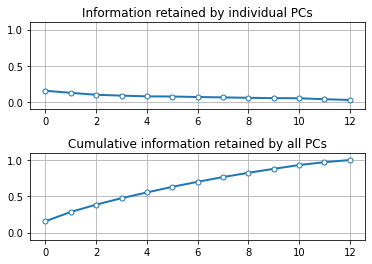

Percent retained 0.9999999999999998


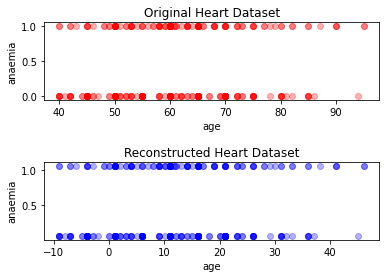

In [177]:
# PCA Analysis of Heart Failure
heart, heart_names = arr_csv("heart_failure_clinical_records_dataset.csv")
# removing the classification column
print(heart.shape)
X, P, e_scaled = pca_svd(heart)
total_retained = 0
print()
print(heart_names)
print("Maximum visualized clustering retained: ")

X_rec = reconstruct(heart, heart.shape[1])
x = heart[:, 0]
y = heart[:, 1]
x = X_rec[:, 0]
y = X_rec[:, 1]
fig, ax = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.8)
ax[0].plot(heart[:, 0], heart[:, 1], 'ob', alpha=0.3, c='r')
ax[1].plot(X_rec[:, 0], X_rec[:, 1], 'or', alpha=0.3, c='b')
ax[0].set_title("Original Heart Dataset")
ax[1].set_title("Reconstructed Heart Dataset")
ax[1].set_xlabel(heart_names[0])
ax[1].set_ylabel(heart_names[1])
ax[0].set_xlabel(heart_names[0])
ax[0].set_ylabel(heart_names[1])
plt.show()

Performing PCA on Iris

Scaled eigenvalues
 [0.766 0.184 0.037 0.008 0.004]


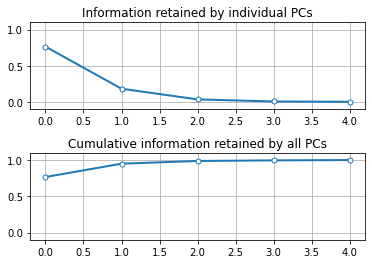

Percent retained 0.9999999999999999

['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species\n']
Maximum visualized clustering retained: 


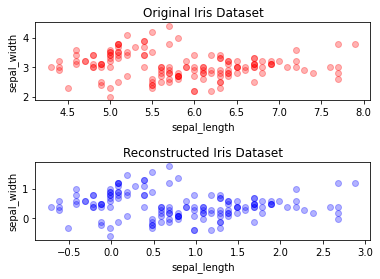

In [178]:
iris, iris_names = arr_csv("iris.data")
iris_rec = reconstruct(iris, iris.shape[1])
X, P, e_scaled = pca_svd(iris)
print()
print(iris_names)
print("Maximum visualized clustering retained: ")
fig, ax = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.8)
ax[0].plot(iris[:, 0], iris[:, 1], 'ob', alpha=0.3, c='r')
ax[1].plot(iris_rec[:, 0], iris_rec[:, 1], 'or', alpha=0.3, c='b')
ax[0].set_title("Original Iris Dataset")
ax[1].set_title("Reconstructed Iris Dataset")
ax[1].set_xlabel(iris_names[0])
ax[1].set_ylabel(iris_names[1])
ax[0].set_xlabel(iris_names[0])
ax[0].set_ylabel(iris_names[1])
plt.show()

Performing Clustering on Iris

In [179]:
# cluster_analysis("iris.data", k=3, class_col=4)

Performing cluster analysis on heartdisease dataset

In [ ]:
cluster_analysis("heart_failure_clinical_records_dataset.csv", k=2, class_col=12)

Means (1, 12)
